Variables to determine car speed

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# total weight of car (minus driver) (lbm)
w_car = 569
# weight of driver (lbm)
w_driver = 130
# weight bias, if less than 0.5, then the rear of the car will have more weight, if more than 0.5, then the front will have more weight
w_bias = 0.507
# length of wheelbase (in)
l = 60
# vertical center of gravity (in)
h = 15

Simple point-mass simulator: Straight Line

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when a constant accerleration is applied
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- boundary conditions require that the initial and final velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is

total time to travel straight 1.38 seconds


<function matplotlib.pyplot.show(close=None, block=None)>

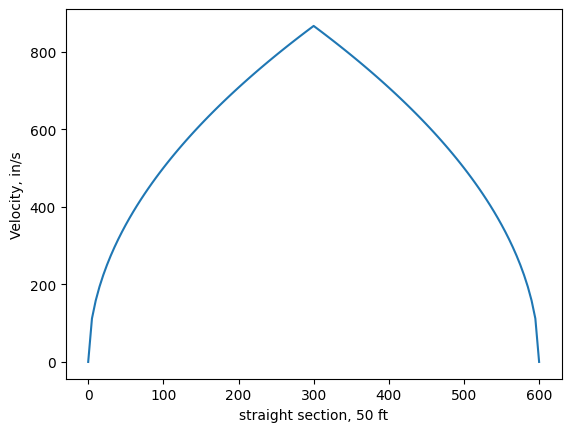

In [76]:
# Run one: How quickly can the car start and stop along a straight line?

# straight line of 50 feet
track = 50
# Convertes track to inches
track = track*12

# discretizing track
dx = 5
n = track/dx

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Friction coefficient of approximately 2.2, will subsitute with more accurate friction ellipse
f_approx = 2.2

a_x = w_car*f_approx

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
for i in np.arange(n):
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_x*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_x*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += np.abs(v3[i+1]-v3[i])/a_x

print(f"total time to travel straight {round(t,2)} seconds")

plt.plot(nodes,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show

Simple point-mass simulator: Oval Track

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# 1st straight line of 50 feet
s1 = 50*12
# 1st corner (35ft radius)
t1 = np.pi()*35
# 2nd straight line of 50 ft
s2 = 50*12
# 2nd corner (25ft radius)
t2 = np.pi()*25

# Total Length of track
track = s1 + s2 + t1 + t2

# discretizing track
dx = 5
n = track/dx

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Friction coefficient of approximately 2.2, will subsitute with more accurate friction ellipse
f_approx = 2.2

# Maximum acceleration in any direction
a = w_car*f_approx

# Determining maximum lateral acceleration for the two corners

# 35 ft corner
v_c1 = np.sqrt(a*35)
# 25 ft corner
v_c2 = np.sqrt(a*25)

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
for i in np.arange(n):
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += np.abs(v3[i+1]-v3[i])/a

print(f"total time to travel straight {round(t,2)} seconds")

plt.plot(nodes,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show